# Importamos bibliotecas necesarias

In [1]:
from sys import maxsize #para imprimir arrays completos
import numpy as np
import pandas as pd

from sklearn import preprocessing #para normalizar datos
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn import metrics

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Para importar Notebooks propias

##### Desde Jupyter no se importar archivos python planos, sino notebooks que tienen una codificación mas complicada. Para poder importar una notebook correctamente hay que agregar los siguientes métodos (tomado de https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Importing%20Notebooks.html)

In [2]:
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

In [3]:
def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path

In [4]:
class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

In [5]:

class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

In [6]:
sys.meta_path.append(NotebookFinder())

# Importamos biblioteca propia

In [7]:
#luego de ejecutar las celdas anteriores, se puede importar la biblioteca propia
#si da errores, probar con hacer restart del kernel
import Desafio_2_aux

importing Jupyter notebook from Desafio_2_aux.ipynb


# Leer el data set desde el archivo csv

In [8]:
pathArchivoDataSet = 'properatti_2.csv'
df = pd.read_csv(pathArchivoDataSet)

In [9]:
df.head(5)

,property_type,place_name,state_name,price,surface_covered_in_m2,surface_not_covered_in_m2,price_usd_per_m2,rooms,lat_mediaPorZona,lon_mediaPorZona,pileta,cochera,balcon,terraza,parrilla
0,PH,mataderos,Capital Federal,62000.0,40.000000,15.0,1127.272727,2.0,-34.666326,-58.519094,0,0,0,0,0
1,apartment,la plata,Bs.As. G.B.A. Zona Sur,150000.0,69.891566,0.0,2146.181693,3.0,-34.924277,-57.965973,0,1,1,0,0
2,apartment,mataderos,Capital Federal,72000.0,55.000000,0.0,1309.090909,2.0,-34.666326,-58.519094,0,0,0,0,0
3,PH,liniers,Capital Federal,95000.0,92.565511,0.0,1026.300175,3.0,-34.643508,-58.516984,0,0,0,0,0
4,apartment,centro,Buenos Aires Costa Atlántica,64000.0,35.000000,0.0,1828.571429,4.0,-38.000247,-57.547260,0,0,0,0,0


# Definimos el subset de datos del cual generaremos el modelo

### Nos quedamos con el subset de datos relacionados a Capital Federal

In [10]:

filtroParaElSubsetDeDatos = ['Santa Fe']

In [11]:
df_subset = Desafio_2_aux.getSubDataFrameByStateName(df, filtroParaElSubsetDeDatos)

Sub data frame Info: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8012 entries, 9 to 109205
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   property_type              8012 non-null   object 
 1   place_name                 8012 non-null   object 
 2   price                      8012 non-null   float64
 3   surface_covered_in_m2      8012 non-null   float64
 4   surface_not_covered_in_m2  8012 non-null   float64
 5   price_usd_per_m2           8012 non-null   float64
 6   rooms                      8012 non-null   float64
 7   lat_mediaPorZona           8012 non-null   float64
 8   lon_mediaPorZona           8012 non-null   float64
 9   pileta                     8012 non-null   int64  
 10  cochera                    8012 non-null   int64  
 11  balcon                     8012 non-null   int64  
 12  terraza                    8012 non-null   int64  
 13  parrilla               

# Analizamos outliers y los sacamos del data frame

### Vemos la distribucion de los datos en gráficos para tratar de identificar los outliers que tenemos

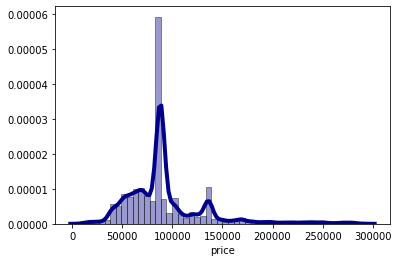

In [12]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'price')


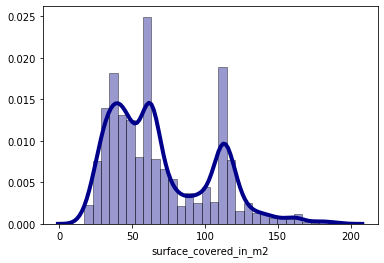

In [13]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'surface_covered_in_m2')

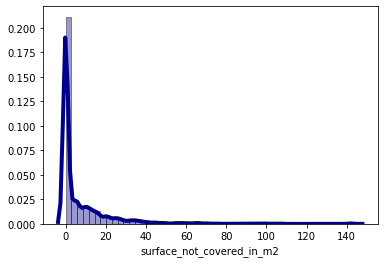

In [14]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'surface_not_covered_in_m2')

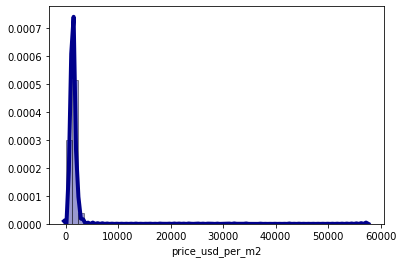

In [15]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'price_usd_per_m2')

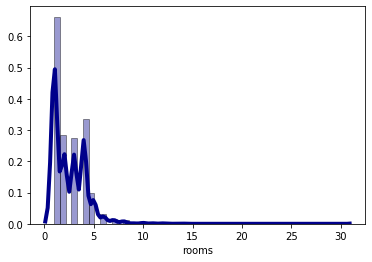

In [16]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'rooms')

### Removemos los outliers

In [17]:
df_subset.describe()

,price,surface_covered_in_m2,surface_not_covered_in_m2,price_usd_per_m2,rooms,lat_mediaPorZona,lon_mediaPorZona,pileta,cochera,balcon,terraza,parrilla
count,8012.000000,8012.000000,8012.000000,8012.000000,8012.000000,8012.000000,8012.000000,8012.000000,8012.000000,8012.000000,8012.000000,8012.000000
mean,92092.907157,69.098438,7.307335,1665.470209,2.552297,-32.742832,-60.694002,0.093235,0.402022,0.304044,0.258487,0.214304
std,39784.305390,34.315078,14.725724,2997.072620,1.712485,0.538072,0.189931,0.290780,0.490337,0.460030,0.437830,0.410364
min,10095.060000,17.000000,0.000000,0.600000,1.000000,-38.416097,-63.616672,0.000000,0.000000,0.000000,0.000000,0.000000
25%,69509.346937,41.000000,0.000000,966.602365,1.000000,-32.947316,-60.661852,0.000000,0.000000,0.000000,0.000000,0.000000
50%,88084.667471,62.285277,0.000000,1390.958081,2.000000,-32.947316,-60.661852,0.000000,0.000000,0.000000,0.000000,0.000000
75%,100000.000000,100.000000,9.733355,1692.945102,4.000000,-32.947316,-60.661852,0.000000,1.000000,1.000000,1.000000,0.000000
max,290000.000000,190.000000,144.000000,57382.080000,30.000000,-29.156925,-58.333860,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
#removemos datos por outliers de precio por m2
df_subset = Desafio_2_aux.removeRowsWithOutliersFromDataFrame(df_subset, 'price_usd_per_m2', 500, 2500)

In [19]:
#removemos outliers por rooms
df_subset = Desafio_2_aux.removeRowsWithOutliersFromDataFrame(df_subset, 'rooms', 1, 5)

In [20]:
df_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6757 entries, 0 to 6756
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   property_type              6757 non-null   object 
 1   place_name                 6757 non-null   object 
 2   price                      6757 non-null   float64
 3   surface_covered_in_m2      6757 non-null   float64
 4   surface_not_covered_in_m2  6757 non-null   float64
 5   price_usd_per_m2           6757 non-null   float64
 6   rooms                      6757 non-null   float64
 7   lat_mediaPorZona           6757 non-null   float64
 8   lon_mediaPorZona           6757 non-null   float64
 9   pileta                     6757 non-null   int64  
 10  cochera                    6757 non-null   int64  
 11  balcon                     6757 non-null   int64  
 12  terraza                    6757 non-null   int64  
 13  parrilla                   6757 non-null   int64

# Analizamos las variables categóricas

rosario                       5775
santa fe                       476
san lorenzo                     85
castellanos                     71
esperanza                       64
funes                           53
roldán                          44
rafaela                         29
reconquista                     19
villa constitución              18
granadero baigorria             18
capitán bermúdez                16
iriondo                         14
santo tomé                      10
las rosas                        8
san jorge                        6
avellaneda                       5
ibarlucea                        5
sauce viejo                      4
arocena                          4
coronda                          3
san josé del rincón              3
bella italia                     2
providencia                      2
humboldt                         2
arroyo leyes                     2
colastiné                        2
pérez                            1
monte vera          

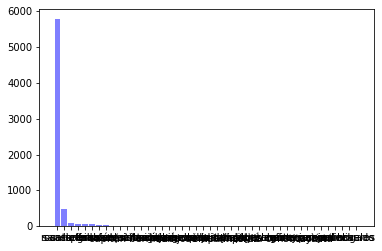

apartment    5423
house        1127
store         152
PH             55
Name: property_type, dtype: int64


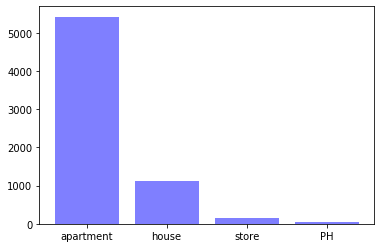

In [21]:
Desafio_2_aux.analyzeCategoricalData(df_subset, ['place_name', 'property_type'])

### Creamos variables dummies a partir de la variable categorica

In [22]:
df_subset = Desafio_2_aux.createDummiesForVariables(df_subset, ['place_name', 'property_type'])

In [23]:
df_subset.head()

,property_type,place_name,price,surface_covered_in_m2,surface_not_covered_in_m2,price_usd_per_m2,rooms,lat_mediaPorZona,lon_mediaPorZona,pileta,...,place_name_santa fe,place_name_santo tomé,place_name_sauce viejo,place_name_serodino,place_name_sunchales,place_name_susana,place_name_villa constitución,property_type_apartment,property_type_house,property_type_store
0,apartment,rosario,88084.667471,55.000000,0.0,1601.539409,2.0,-32.947316,-60.661852,0,...,0,0,0,0,0,0,0,1,0,0
1,apartment,rosario,88084.667471,55.000000,0.0,1601.539409,2.0,-32.947316,-60.661852,0,...,0,0,0,0,0,0,0,1,0,0
2,apartment,rosario,88084.667471,63.000000,0.0,1398.169325,1.0,-32.947316,-60.661852,0,...,0,0,0,0,0,0,0,1,0,0
3,house,san lorenzo,109282.491200,125.000000,54.0,610.516711,5.0,-32.881885,-60.785617,0,...,0,0,0,0,0,0,0,0,1,0
4,house,santa fe,101939.337902,118.617021,0.0,859.398902,5.0,-31.678706,-60.705142,0,...,1,0,0,0,0,0,0,0,1,0


# Guardamos un data frame auxiliar con la relacion entre los dummies y el dato place_name

### Data frame auxiliar para place name

In [24]:
place_name_dummies = Desafio_2_aux.generateAuxiliarDataFrameForDummies(df_subset, 'place_name')
place_name_dummies

,place_name,place_name_arequito,place_name_arocena,place_name_arroyo leyes,place_name_arroyo seco,place_name_avellaneda,place_name_bella italia,place_name_capitán bermúdez,place_name_castellanos,place_name_cayastá,...,place_name_san jorge,place_name_san josé del rincón,place_name_san lorenzo,place_name_santa fe,place_name_santo tomé,place_name_sauce viejo,place_name_serodino,place_name_sunchales,place_name_susana,place_name_villa constitución
0,rosario,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,san lorenzo,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,santa fe,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
6,reconquista,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,esperanza,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
45,rafaela,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65,bella italia,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
88,granadero baigorria,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
120,castellanos,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
134,funes,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Data frame auxiliar para property_type

In [25]:
proeprty_type_dummies = Desafio_2_aux.generateAuxiliarDataFrameForDummies(df_subset, 'property_type')
proeprty_type_dummies

,property_type,property_type_apartment,property_type_house,property_type_store
0,apartment,1,0,0
3,house,0,1,0
15,PH,0,0,0
47,store,0,0,1


# Generamos el objeto para el K Fold

In [26]:
#generamos un K Fold de 5 pasos para el entrenamiento de los modelos
cv = KFold(5, shuffle=True, random_state=10)

# Quitamos las columnas que no van a estar en el modelo

In [27]:
#quitamos las columnas que no van a participar en el modelo
df_model_columns = df_subset.drop(labels= ["price", "property_type", "place_name"], axis=1)
df_model_columns

,surface_covered_in_m2,surface_not_covered_in_m2,price_usd_per_m2,rooms,lat_mediaPorZona,lon_mediaPorZona,pileta,cochera,balcon,terraza,...,place_name_santa fe,place_name_santo tomé,place_name_sauce viejo,place_name_serodino,place_name_sunchales,place_name_susana,place_name_villa constitución,property_type_apartment,property_type_house,property_type_store
0,55.000000,0.000000,1601.539409,2.0,-32.947316,-60.661852,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,55.000000,0.000000,1601.539409,2.0,-32.947316,-60.661852,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,63.000000,0.000000,1398.169325,1.0,-32.947316,-60.661852,0,0,1,1,...,0,0,0,0,0,0,0,1,0,0
3,125.000000,54.000000,610.516711,5.0,-32.881885,-60.785617,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,118.617021,0.000000,859.398902,5.0,-31.678706,-60.705142,0,1,1,0,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6752,33.000000,0.000000,1699.505152,1.0,-32.947316,-60.661852,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
6753,25.000000,2.000000,1744.825185,1.0,-32.947316,-60.661852,0,0,1,1,...,0,0,0,0,0,0,0,1,0,0
6754,34.000000,6.000000,2202.116687,1.0,-32.947316,-60.661852,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
6755,91.000000,0.000000,1098.901099,4.0,-32.947316,-60.661852,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


# Generamos un modelo con Regresion Lineal

In [28]:
#definimos como variables para entrenamiento todas las del data frame excepto el precio por m2
#el valor precio por m2 será lo que el modelo intente calcular
X = df_model_columns.drop('price_usd_per_m2', axis=1)
y = df_model_columns['price_usd_per_m2']

In [29]:
#seleccionamos un tamaño para el set de test del 10% del data frame
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=10)

### Realizamos un entrenamiento con el k fold con k = 5

In [30]:
#el metodo devuelve el modelo, las predicciones y un data frame para comparar valores reales vs obtenidos
regresionLineal_model, regresionLineal_predicciones, df_regresion_lineal_prediccion_vs_real, scores_lineal = \
                Desafio_2_aux.generateSimpleLinearRegression(X_train, X_test, y_train, y_test, cv)

Score regresión lineal con 5-fold: [-2.27708664e+27 -1.49629261e+26 -1.23257993e+26 -3.66711113e+25
 -5.43420181e+25]



Intercept: 
1593.4834504800167



Coeficientes: 
[-2.56439979e+02 -1.27348920e+02  1.03622703e+01 -3.73437902e+15
 -1.21615434e+15  2.10871243e+01  8.67128638e+00  2.71169707e+01
 -5.99247170e+00  3.23454694e+00 -8.01124764e+14  1.87534643e+14
  2.37854491e+14  1.06593942e+13  1.81712575e+14  1.46186114e+14
  8.99895311e+13  8.50309658e+14  2.38613588e+14  2.12638165e+14
  1.41847867e+14 -1.54111357e+13  1.17275480e+13  1.06336695e+15
  3.09043209e+13  8.58616136e+13  2.50272622e+14  1.77828470e+14
  2.56431982e+13  9.93213028e+13  1.75257087e+14 -7.23775397e+13
  1.53155910e+14  3.57014772e+13  2.44705592e+14  1.30305895e+14
 -9.80685540e+11  5.49573305e+14  2.10024712e+15 -1.98259862e+13
  4.44866743e+14 -2.99561160e+14  5.56941592e+14  8.79227733e+12
  2.73016212e+14  9.07204832e+13  2.84316186e+15  4.11271564e+14
  2.38607356e+14  2.15209610e+13  1.26195107e+14  

In [31]:
df_regresion_lineal_prediccion_vs_real

,Real,Predichos,Diferencia
2993,1762.629762,1290.248201,472.381561
191,2199.908652,1279.498201,920.410451
139,1228.004507,1226.794808,1.209699
2279,1144.574333,986.248201,158.326133
5859,1247.204224,978.748201,268.456024
...,...,...,...
6087,606.480517,767.044808,-160.564291
5435,1804.991839,1315.998201,488.993638
692,1232.859436,1443.998201,-211.138764
5998,765.953630,979.498201,-213.544570


# Redefinimos los data frames para modelar, ya que ahora necesitamos un subconjunto de prueba sobre el data frame total

In [32]:
#seleccionamos un tamaño para el set de test del 25% del data frame
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

# Generamos el modelo para Ridge Cross Validation

In [33]:
#el metodo devuelve el modelo, las predicciones y un data frame para comparar valores reales vs obtenidos
model_ridge, RidgeCV_predicciones, df_ridge_prediccion_vs_real, model_ridge_score = \
                Desafio_2_aux.generateRidgeCV(X_train, X_test, y_train, y_test, np.linspace(4,10,500), cv)

Score Ridge CV: [0.4268706  0.38228269 0.40085979 0.4196418  0.43746051]
Alpha Ridge CV: 10.0
Coeficientes:  [-2.51130322e+02 -1.31948032e+02  9.62402254e+00 -4.59749362e+00
 -3.52062494e+00  2.03718136e+01  1.19440963e+01  2.72646183e+01
 -3.50749262e+00  8.23371008e-01  9.81105767e+00  2.22047597e+00
  1.49780695e+00  1.58859713e+00  3.24209887e+00  1.58166129e+00
 -3.07612851e+00  1.35649441e+01  1.76154616e+00 -1.20595231e+00
  3.29168612e+00  0.00000000e+00 -9.49078051e-01 -2.44624491e+01
  3.15446416e+01  3.96905077e+00  0.00000000e+00  1.81966781e+00
  8.80762497e+00 -4.45410281e+00  1.13712507e+00 -4.19756424e+00
 -8.04299222e-01 -1.31460791e+00  1.31485624e+01  1.26883359e+00
 -5.03514155e+00 -8.64216952e+00 -6.72604422e-01 -2.36253770e-01
  7.75602997e+01 -7.51597109e-01  0.00000000e+00  9.44065732e+00
  1.57425385e+00  1.84654458e+01 -1.30092766e+01  8.06625067e-01
  9.88638939e-01  0.00000000e+00  1.26147746e+00  7.66742184e-01
 -1.07751880e+01  5.50788399e+01  9.96472985e+

In [34]:
df_ridge_prediccion_vs_real

,Real,Predichos,Diferencia
2993,1762.629762,1298.481022,464.148740
191,2199.908652,1288.597984,911.310668
139,1228.004507,1249.939787,-21.935280
2279,1144.574333,997.190170,147.384163
5859,1247.204224,979.712872,267.491352
...,...,...,...
6423,859.398902,872.777340,-13.378437
3545,1797.646275,1613.850449,183.795826
1598,1957.437055,1594.523119,362.913936
121,1399.413968,1410.274504,-10.860536


# Generamos el modelo para Lasso Cross Validation

In [35]:
model_lasso, LassoCV_predicciones, df_lasso_prediccion_vs_real, scores_lasso = \
        Desafio_2_aux.generateLassoCV(X_train, X_test, y_train, y_test, np.linspace(0.001,1,300), cv)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureW




Intercept: 



1389.5864849266052



Coeficientes: 



[-2.50923216e+02 -1.32020388e+02  8.98032006e+00 -6.76420976e-01
 -0.00000000e+00  2.02342134e+01  1.17766003e+01  2.71157378e+01
 -3.03792813e+00  4.58474730e-01  1.08112500e+01  1.44476432e+00
  7.01687785e-01  9.84706646e-01  1.20640166e+00  9.52842403e-01
 -3.71014413e+00  1.16866820e+01  8.04261118e-01 -1.32535743e+00
  2.59108133e+00  0.00000000e+00 -9.54370578e-01 -2.66828115e+01
  2.99656198e+01  2.67521762e+00  0.00000000e+00  1.05415595e+00
  8.19551160e+00 -4.89842421e+00  3.66812532e-01 -4.04899073e+00
 -9.34451997e-01 -1.26607722e+00  1.24793510e+01  6.07308082e-01
 -4.95331964e+00 -9.43760373e+00 -4.21081730e+00 -1.10918466e+00
  7.06367544e+01 -0.00000000e+00  0.00000000e+00  9.07994011e+00
  7.96362609e-01  1.62678251e+01 -2.01595160e+01 -3.78166121e-02
  3.65435007e-02  0.00000000e+00  7.18551415e-01  2.71605763e-01
 -1.16633917e+01  4.75096166e+01  9.25963180e+01  3.21286889e+01]



MAE: 243.45238604331988
MSE:

In [36]:
df_lasso_prediccion_vs_real

,Real,Predichos,Diferencia
2993,1762.629762,1298.239116,464.390646
191,2199.908652,1288.217334,911.691318
139,1228.004507,1249.243234,-21.238726
2279,1144.574333,996.571724,148.002609
5859,1247.204224,978.860605,268.343619
...,...,...,...
6423,859.398902,874.320853,-14.921950
3545,1797.646275,1614.039023,183.607252
1598,1957.437055,1594.516061,362.920994
121,1399.413968,1406.658136,-7.244168


# Verificamos los resultados

### Visualizamos los scores de los modelos

In [37]:
print("Score Train Lineal: " ,scores_lineal)
print("Score Train Ridge: " , model_ridge_score)
print("Score Train Lasso: " ,  scores_lasso)

Score Train Lineal:  [-2.27708664e+27 -1.49629261e+26 -1.23257993e+26 -3.66711113e+25
 -5.43420181e+25]
Score Train Ridge:  [0.4268706  0.38228269 0.40085979 0.4196418  0.43746051]
Score Train Lasso:  [0.42672831 0.38268633 0.40071804 0.41952937 0.43759332]


### Visualizamos los errores cuadraticos medios

In [38]:
print("Train RMSE Lineal: " + str(np.sqrt(metrics.mean_squared_error(df_regresion_lineal_prediccion_vs_real.Real, df_regresion_lineal_prediccion_vs_real.Predichos))))
print("Train RMSE RidgeCV: " + str(np.sqrt(metrics.mean_squared_error(df_ridge_prediccion_vs_real.Real, df_ridge_prediccion_vs_real.Predichos))))
print("Train RMSE Lasso: " + str(np.sqrt(metrics.mean_squared_error(df_lasso_prediccion_vs_real.Real, df_lasso_prediccion_vs_real.Predichos))))

Train RMSE Lineal: 348.177242016861
Train RMSE RidgeCV: 331.9808240783797
Train RMSE Lasso: 331.92160988343625


In [39]:
print ('Train R2 Lineal:', metrics.r2_score(df_regresion_lineal_prediccion_vs_real.Real, df_regresion_lineal_prediccion_vs_real.Predichos))
print ('Train R2 RidgeCV:', metrics.r2_score(df_ridge_prediccion_vs_real.Real, df_ridge_prediccion_vs_real.Predichos))
print ('Train R2 Lasso:', metrics.r2_score(df_lasso_prediccion_vs_real.Real, df_lasso_prediccion_vs_real.Predichos))

Train R2 Lineal: 0.43895410823956305
Train R2 RidgeCV: 0.4054561458810133
Train R2 Lasso: 0.4056682201539543


### Visualizamos en histogramas como aportan los coeficientes en cada modelo

### Coeficientes de la Regresion Lineal

In [40]:
df_coeficientes_lineal = Desafio_2_aux.generateDataFrameFromModelCoeficients(regresionLineal_model.coef_, X.columns)

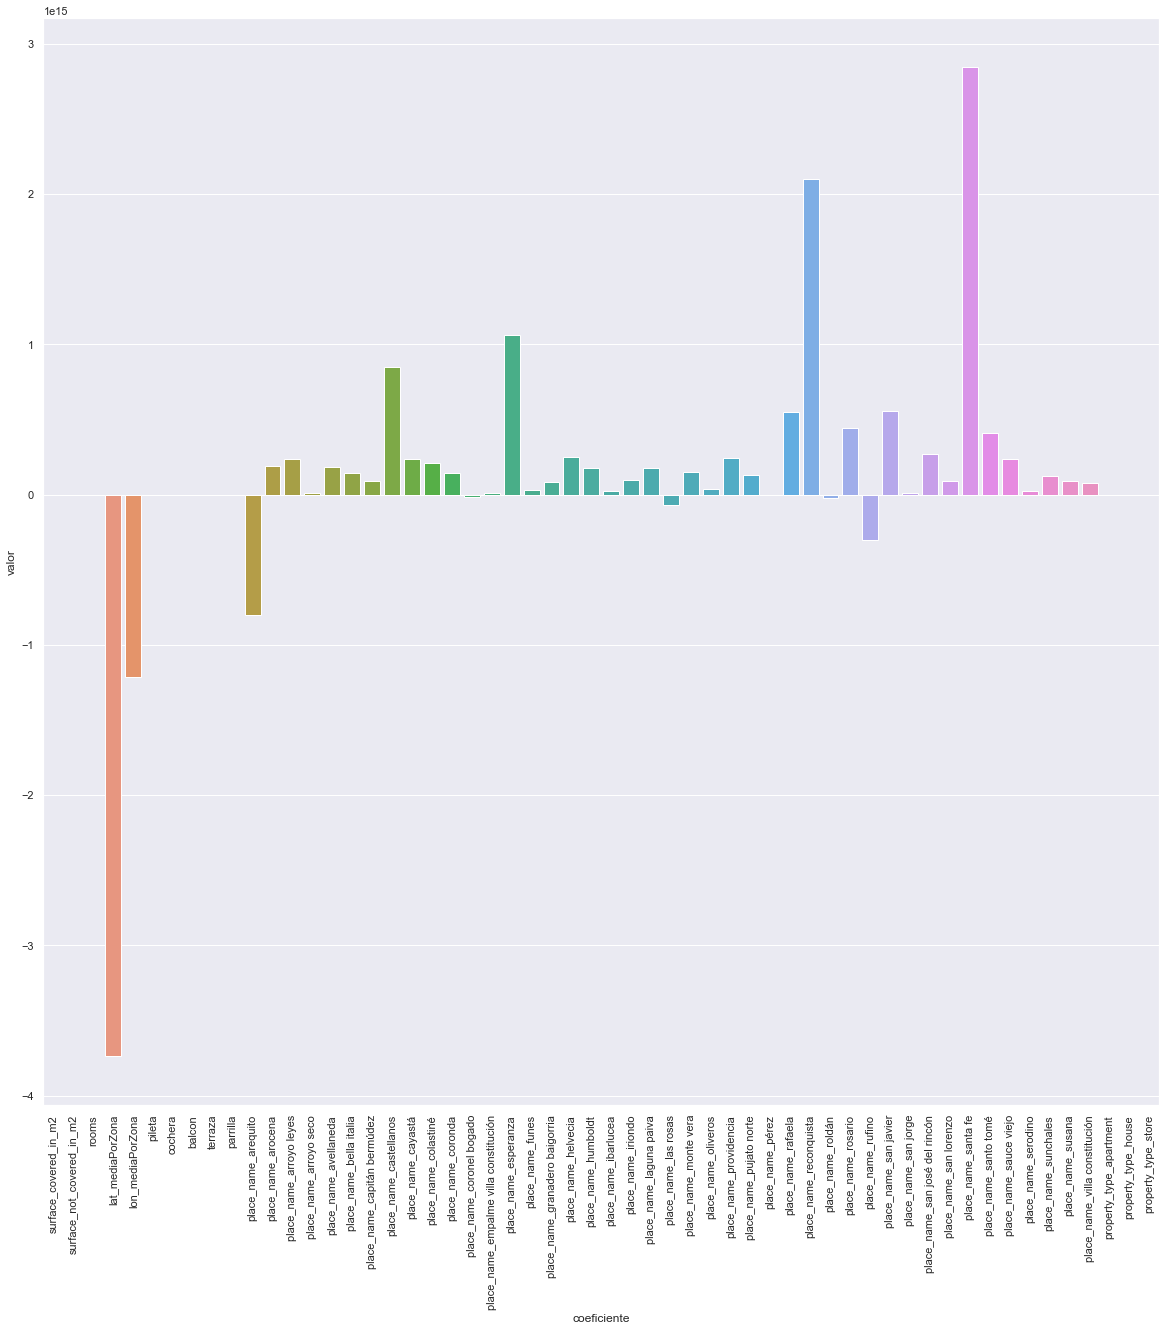

In [41]:
sns.set(rc={'figure.figsize':(20,20)});
ax = sns.barplot(x="coeficiente", y="valor", data=df_coeficientes_lineal);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

### Coeficientes RidgeCV

In [42]:
df_coeficientes_ridge = Desafio_2_aux.generateDataFrameFromModelCoeficients(model_ridge.coef_, X.columns)

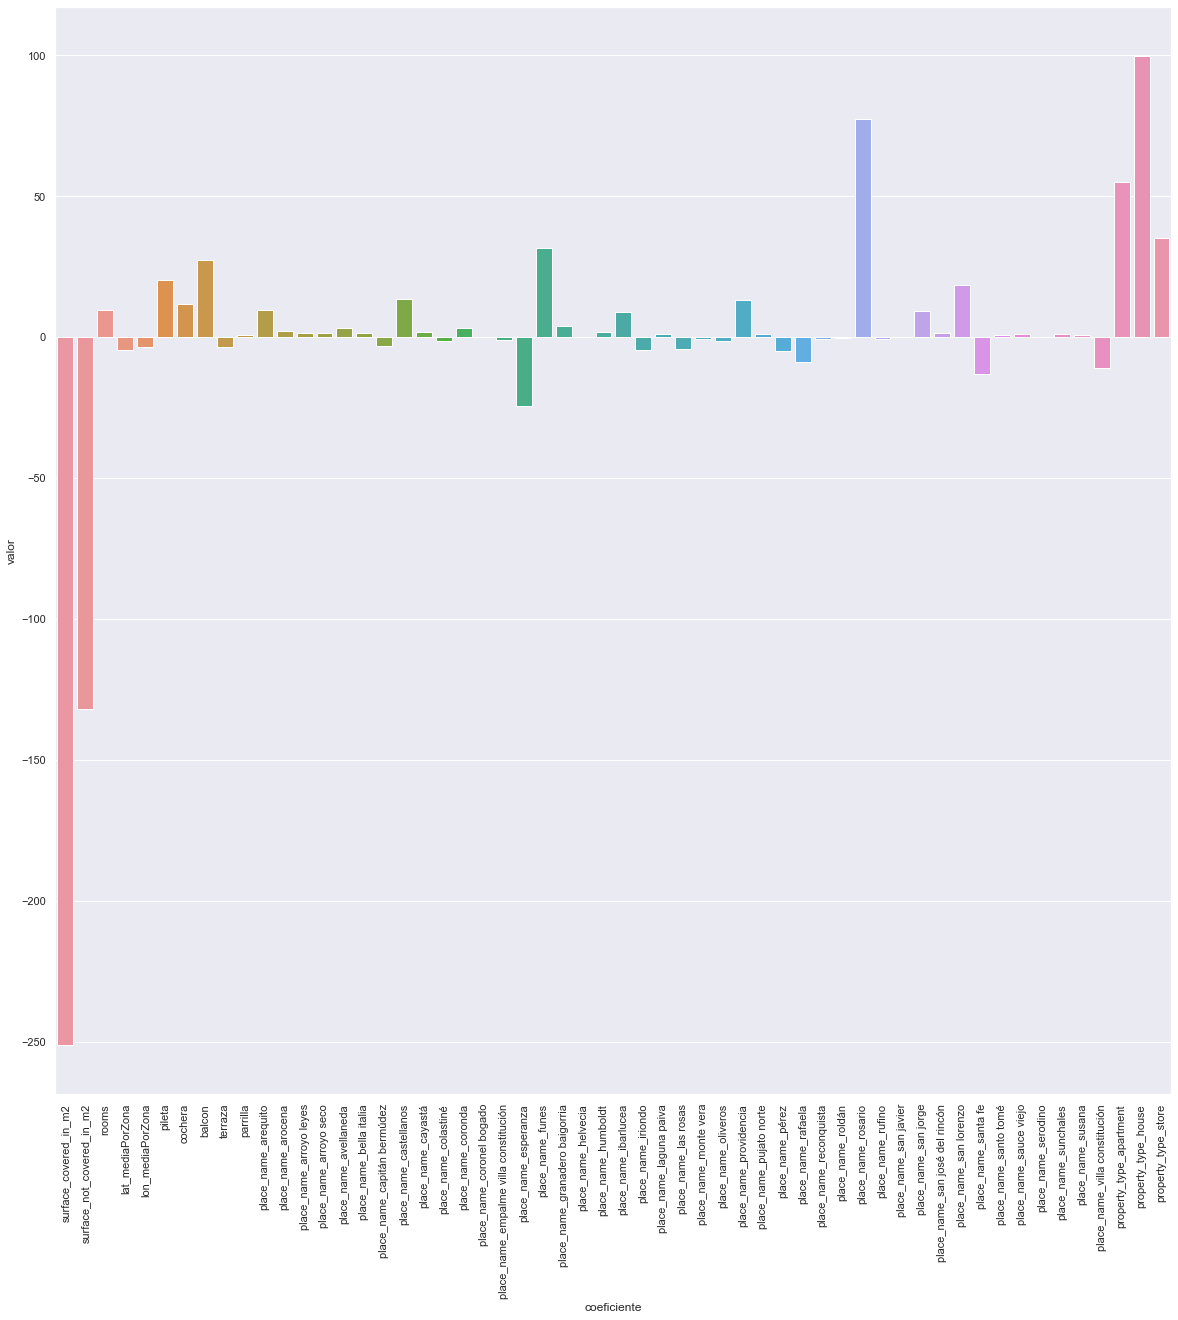

In [43]:
sns.set(rc={'figure.figsize':(20,20)});
ax = sns.barplot(x="coeficiente", y="valor", data=df_coeficientes_ridge);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

### Coeficientes para el modelo Lasso

In [44]:
df_coeficientes_lasso = Desafio_2_aux.generateDataFrameFromModelCoeficients(model_lasso.coef_, X.columns)

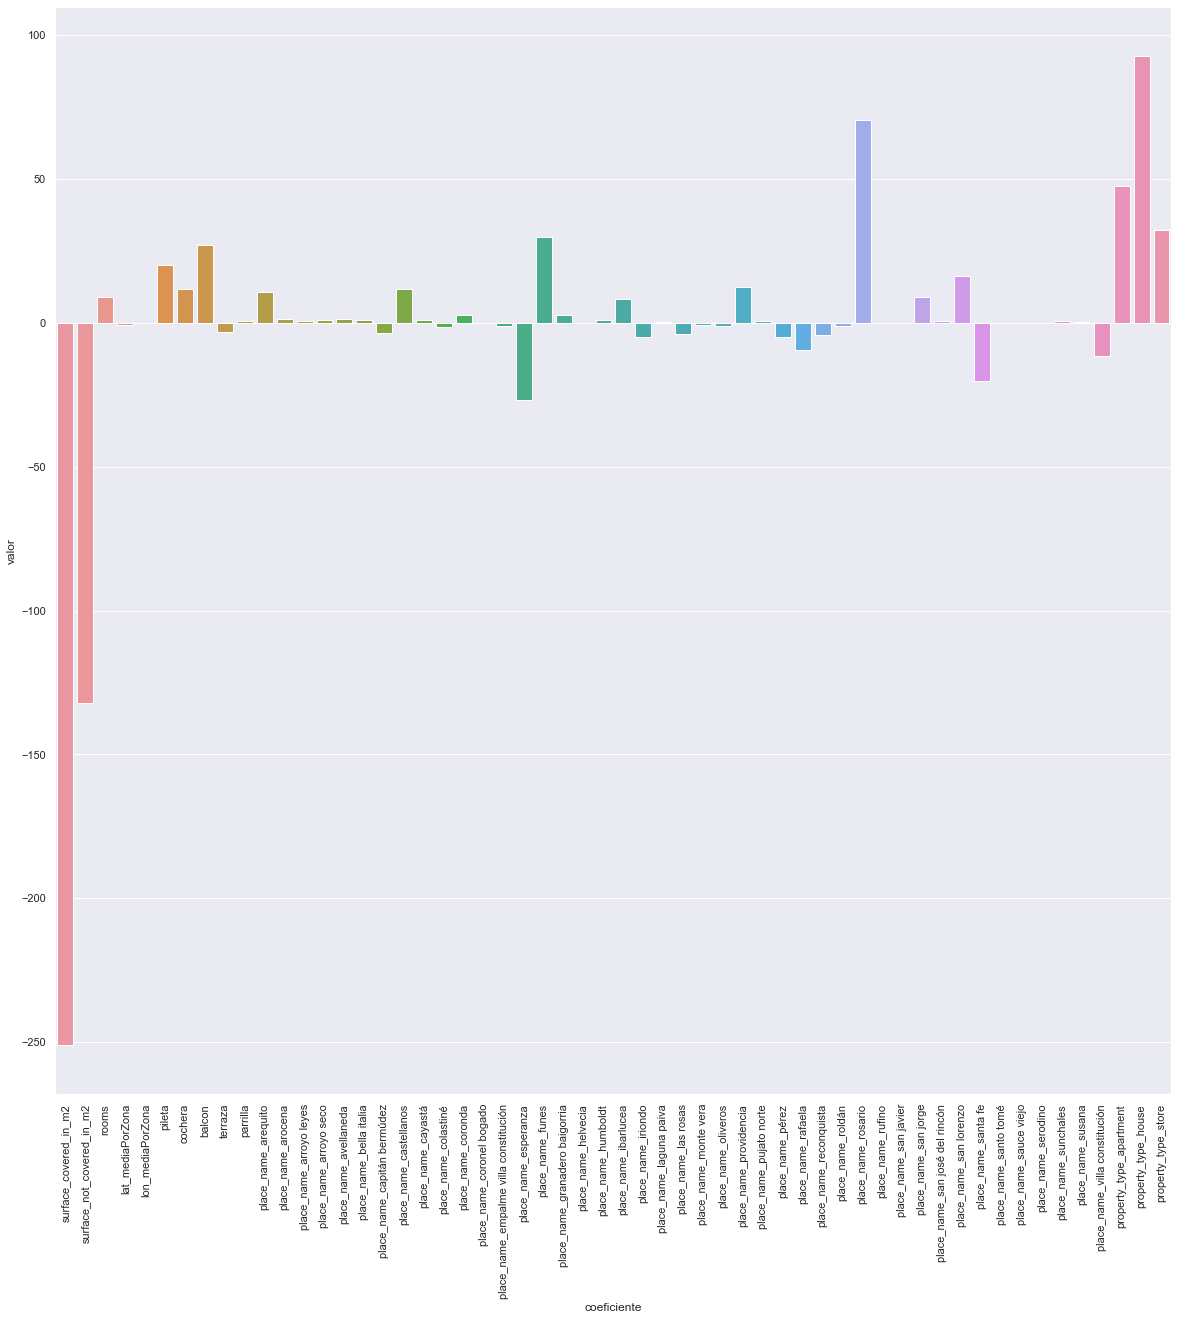

In [45]:
sns.set(rc={'figure.figsize':(20,20)});
ax = sns.barplot(x="coeficiente", y="valor", data=df_coeficientes_lasso);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

Una posible mejora que se puede agregar al análisis es ver la diferencia entre los valores predichos vs los valores reales por barrio. Para eso es necesario, cuando se hace el split para el entrenamiento y el testeo, que seleccione subconjuntos de acuerdo a las cantidades de filas para cada barrio. Porque por ejemplo el barrio de Palermo tiene mas de 2000 registros en el dataset, mientras que hay otros barrios, como Parque Chas, que no superan los 20